In [74]:
import numpy as np
import pandas as pd
import torch
import random

from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torchvision.models.detection import ssd300_vgg16
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Зададим класс для создания датасета

In [82]:
# Определим функцию которая будет отвечать за трансформацию и аугментацию (пока нормализацию) датасета
transforms_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# /content/test.csv
class BCCDDataset(Dataset):
    def __init__(self, data_folder='/content/BCCD_Dataset/'):
        self.data_folder = data_folder
        self.labels = pd.read_csv(os.path.join(data_folder,"test.csv"))
        self.images = self.labels.filename.unique()
        self.classes = ['Background'] + list(self.labels.cell_type.unique())
        self.classes_idx = {w: i for i, w in enumerate(self.classes)}

    def __getitem__(self, ix):
        # load images and masks
        image_id = self.images[ix]
        img = Image.open(os.path.join(self.data_folder + 'BCCD/JPEGImages', image_id)).convert("RGB")

        image = transforms_imgs(img).to(device)

        x = self.labels
        x = x[x.filename == image_id]
        x = x[x.xmin < x.xmax]
        x = x[x.ymin < x.ymax]
        x = np.array(x)
        for i in range(len(x)):
            x[i,1]=self.classes_idx[x[i,1]]

        target = {}
        target["boxes"] = torch.as_tensor(x[:,[2,4,3,5]].astype(float), dtype=torch.float32).to(device)
        target["labels"] = torch.as_tensor(x[:,1].astype(int), dtype=torch.int64).to(device)

        return image, target

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def get_image(self, idx):
        filename = self.images[idx]
        img = Image.open(os.path.join(self.data_folder + 'BCCD/JPEGImages',filename)).convert("RGB")
        return img

#### Сформируем датасет и зададим модель

In [84]:
dataset = BCCDDataset()

test_images = random.sample(range(0, len(dataset)), round(len(dataset)/5))
test_images.sort()

train = list(set(range(len(dataset))) - set(test_images))

In [ ]:
model = ssd300_vgg16(weights='DEFAULT').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

#### Натренируем её

In [77]:
model.train()
batch_size = 30

for ep in range(n_epochs):
    perm = np.random.permutation(train)
    i, bb_loss, cl_loss, loss = 0, 0, 0, 0
    while i < len(perm):
        image_batch=[]
        target_batch=[]

        for j in range(batch_size):
            if i >= len(perm):
                break
            image, target = dataset[perm[i]]
            image_batch.append(image)
            target_batch.append(target)
            i +=1

        optimizer.zero_grad()
        pred = model(image_batch, target_batch)
        loss_ep = pred['bbox_regression'] * pred['bbox_regression'] * 20 + pred['classification']
        loss_ep.backward()
        optimizer.step()
        bb_loss += pred['bbox_regression'].item()
        cl_loss += pred['classification'].item()
        loss += loss_ep.item()

    print('%3d%%. Loss: %.3f, bbox: %.3f, classification: %.3f' %
          (((ep + 1) / n_epochs)*100, loss/(ep + 1), bb_loss/(ep + 1), cl_loss/(ep + 1)))

  5%. Loss: 273.582, bbox: 9.989, classification: 53.006
 10%. Loss: 47.939, bbox: 3.012, classification: 11.149
 15%. Loss: 23.448, bbox: 1.666, classification: 6.587
 20%. Loss: 14.101, bbox: 1.089, classification: 4.525
 25%. Loss: 9.516, bbox: 0.777, classification: 3.435
 30%. Loss: 6.808, bbox: 0.580, classification: 2.736
 35%. Loss: 5.130, bbox: 0.450, classification: 2.282
 40%. Loss: 3.985, bbox: 0.356, classification: 1.941
 45%. Loss: 3.169, bbox: 0.287, classification: 1.674
 50%. Loss: 2.596, bbox: 0.238, classification: 1.457
 55%. Loss: 2.145, bbox: 0.197, classification: 1.290
 60%. Loss: 1.818, bbox: 0.168, classification: 1.143
 65%. Loss: 1.546, bbox: 0.142, classification: 1.024
 70%. Loss: 1.314, bbox: 0.120, classification: 0.911
 75%. Loss: 1.155, bbox: 0.104, classification: 0.825
 80%. Loss: 1.008, bbox: 0.090, classification: 0.745
 85%. Loss: 0.890, bbox: 0.079, classification: 0.676
 90%. Loss: 0.784, bbox: 0.069, classification: 0.611
 95%. Loss: 0.704, bb

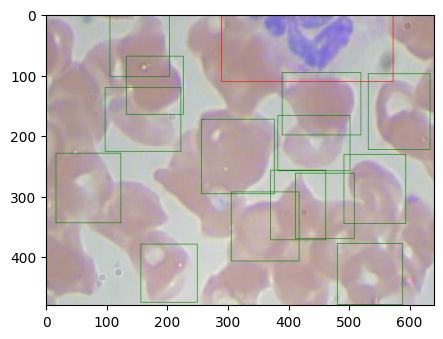

In [94]:
model.eval()
for i in test_images[:1]:
    image, target = dataset[i]
    outputs = model([image])
    image = dataset.get_image(i)
    draw = ImageDraw.Draw(image)
    classes = outputs[0]['labels'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().detach().numpy()
    boxes = outputs[0]['boxes'].cpu().detach().numpy()

    for i,box in enumerate(boxes):
        if scores[i] > 0.5:
            classes[i] = classes[i] if classes[i] < 4 else 0
            cl = ['black','red','green','blue']
            draw.rectangle(xy=box.tolist(), outline=cl[classes[i]])
    plt.figure(figsize=(5, 5))
    plt.imshow(image)